In [1]:
import sys
sys.argv = ['']

In [2]:
from diffuser.utils.arrays import to_torch, to_np, to_device
from diffuser.datasets.d4rl import suppress_output
from scripts.buffer_utils import LoadSequenceDataset
from scripts.buffer_utils import OptimalBuffer
from scripts.mopo.utils_trans import RewardPredictingModel 
from scripts.buffer_utils import augment_trajectories_new
import diffuser.utils as utils

ML_LOGGER_USER is not set. This is required for online usage.


In [3]:
import shutil 
import argparse 
import time 
import pickle 
import sys
import os
import torch
import random
import importlib

In [4]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import pdb

In [6]:
def import_config(config_name):
    module_path = f"detail_configs.{config_name}"
    try:
        module = importlib.import_module(module_path)
        return module.Config    
    except ImportError:
        print(f"Error: Module '{config_name}' not found or has no 'Config' attribute.")
        return None

In [7]:
from ml_logger import logger

Config = import_config('maze')

BASE_WEIGHTS_PATH = os.path.join(Config.bucket, Config.dataset)
save_config_path = os.path.join(BASE_WEIGHTS_PATH, "config")

logger.configure(save_config_path)
torch.backends.cudnn.benchmark = True


✓ created a new logging client
Dashboard: http://app.dash.ml/common/users/cc1547/projects/rainbow/diffstitch/diffuser/AntMaze_Medium-v4/config
Log_directory: /common/home/cc1547/projects/diff_stitch


In [11]:
dataset_config = utils.Config(
		'datasets.CondSequenceDataset',
		savepath='dataset_config.pkl',
		env=Config.dataset,
		horizon=Config.horizon,
		normalizer=Config.normalizer,
		preprocess_fns=Config.preprocess_fns,
		use_padding=Config.use_padding,
		max_path_length=Config.max_path_length,
		include_returns=Config.include_returns,
		returns_scale=Config.returns_scale,
        data_file=Config.data_file,
        stitch=True,
	)
render_config = utils.Config(
        Config.renderer,
        savepath="render_config.pkl",
        env=Config.dataset,
    )

dataset = dataset_config()
renderer = render_config()
observation_dim = dataset.observation_dim
action_dim = dataset.action_dim
loadpath = os.path.join(Config.bucket, Config.dataset, Config.prefix, 'checkpoint')
print('\n\nloadpath = ', loadpath, end = '\n\n')  

[ utils/config ] Imported diffuser.datasets:CondSequenceDataset

[utils/config ] Config: <class 'diffuser.datasets.sequence.CondSequenceDataset'>
    data_file: /common/users/cc1547/dataset/rainbow/stitching_maze/
    env: AntMaze_Medium-v4
    horizon: 80
    include_returns: False
    max_path_length: 1000
    normalizer: LimitsNormalizer
    preprocess_fns: []
    returns_scale: 400.0
    stitch: True
    use_padding: False

[ utils/config ] Saved config to: dataset_config.pkl

[ utils/config ] Imported diffuser.utils:Maze2dRenderer

[utils/config ] Config: <class 'diffuser.utils.rendering.Maze2dRenderer'>
    env: AntMaze_Medium-v4

[ utils/config ] Saved config to: render_config.pkl

class =  <class 'diffuser.datasets.sequence.CondSequenceDataset'>
kwargs =  {}


KeyError: 'rewards'

In [9]:
loadpath = os.path.join(loadpath, f'state_1000000.pt')
state_dict = torch.load(loadpath, map_location=Config.device)

observation_dim = dataset.observation_dim
action_dim = dataset.action_dim
transition_dim = observation_dim

model_config = utils.Config(
		Config.model,
		savepath='model_config.pkl',
		horizon=Config.horizon,
		transition_dim=transition_dim,
		cond_dim=observation_dim,
		dim_mults=Config.dim_mults,
		dim=Config.dim,
		returns_condition=Config.returns_condition,
		device=Config.device,
	)

diffusion_config = utils.Config(
    Config.diffusion,
    savepath='diffusion_config.pkl',
    horizon=Config.horizon,
    observation_dim=observation_dim,
    action_dim=action_dim,
    n_timesteps=Config.n_diffusion_steps,
    loss_type=Config.loss_type,
    clip_denoised=Config.clip_denoised,
    predict_epsilon=Config.predict_epsilon,
    hidden_dim=Config.hidden_dim,
    ## loss weighting
    action_weight=Config.action_weight,
    loss_weights=Config.loss_weights,
    loss_discount=Config.loss_discount,
    returns_condition=Config.returns_condition,
    device=Config.device,
    condition_guidance_w=Config.condition_guidance_w,
)

trainer_config = utils.Config(
		utils.Trainer,
		savepath='trainer_config.pkl',
		train_batch_size=Config.batch_size,
		train_lr=Config.learning_rate,
		gradient_accumulate_every=Config.gradient_accumulate_every,
		ema_decay=Config.ema_decay,
		sample_freq=Config.sample_freq,
		save_freq=Config.save_freq,
		log_freq=Config.log_freq,
		label_freq=int(Config.n_train_steps // Config.n_saves),
		save_parallel=Config.save_parallel,
		bucket=Config.bucket,
		n_reference=Config.n_reference,
        n_samples=Config.n_samples,
		train_device=Config.device,
	)
model = model_config()
diffusion = diffusion_config(model)
trainer = trainer_config(diffusion, dataset, renderer)
# logger.print(utils.report_parameters(model), color='green')
trainer.step = state_dict['step']
trainer.model.load_state_dict(state_dict['model'])
trainer.ema_model.load_state_dict(state_dict['ema'])

NameError: name 'loadpath' is not defined

In [10]:
def get_bad_traj(horizon, dataset, num_optim): 
	from tqdm import tqdm 
	rec = [] 
	for i in tqdm(range(dataset.num_traj)): 
		info = dataset.get_full_info_traj(i)  
		discounted_return = 0 
		for j in range(info['horizon'] - 1, -1, -1):
			discounted_return = discounted_return * 0.99 + info['rew'][j] 
			if info['horizon'] - j > horizon: 
				rec.append([i, j, discounted_return])      
	rec = sorted(rec, key = lambda item: item[2])  
	dic_ret = {} 
	for i in range(30):
		dic_ret[str(i)] = [] 
	for i in tqdm(rec): 
		if i[2] < 0: 
			continue
		dic_ret[str(int(i[2] / 50))].append(i)   
	for i in range(30):
		print(f'{i} : ({i * 50} , {(i + 1) * 50}] = {len(dic_ret[str(i)])}')    
	return rec[-num_optim:], dic_ret 

In [37]:
def get_bad_traj_debug(horizon, dataset, num_optim): 
	from tqdm import tqdm 
	rec = [] 
	for i in tqdm(range(dataset.num_traj)): 
		info = dataset.get_full_info_traj(i)  
		discounted_return = 0 
		for j in range(info['horizon'] - 1, -1, -1):
			discounted_return = discounted_return * 0.99 + info['rew'][j] 
			if info['horizon'] - j > horizon: 
				rec.append([i, j, discounted_return])      
	# rec = sorted(rec, key = lambda item: item[2])  
	dic_ret = {} 
	for i in range(30):
		dic_ret[str(i)] = [] 
	for i in tqdm(rec): 
		if i[2] < 0: 
			continue
		dic_ret[str(int(i[2] / 50))].append(i)   
	for i in range(30):
		print(f'{i} : ({i * 50} , {(i + 1) * 50}] = {len(dic_ret[str(i)])}')    
	return rec, dic_ret 

In [11]:
dynamics_model = RewardPredictingModel(
    device = Config.device, 
    env_name = Config.dataset, 
    load_path = Config.dynamic_model_path
) 

In [50]:
env_dataset    = LoadSequenceDataset(env_name = Config.dataset, data_file=Config.data_file+'antmaze-medium-v0.pkl')
top_k_trajs, dic_ret = get_bad_traj(Config.horizon, env_dataset, Config.top_k)


number of offline data is 1000000

False


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 528182/528182 [00:00<00:00, 989963.37it/s]

0 : (0 , 50] = 528182
1 : (50 , 100] = 0
2 : (100 , 150] = 0
3 : (150 , 200] = 0
4 : (200 , 250] = 0
5 : (250 , 300] = 0
6 : (300 , 350] = 0
7 : (350 , 400] = 0
8 : (400 , 450] = 0
9 : (450 , 500] = 0
10 : (500 , 550] = 0
11 : (550 , 600] = 0
12 : (600 , 650] = 0
13 : (650 , 700] = 0
14 : (700 , 750] = 0
15 : (750 , 800] = 0
16 : (800 , 850] = 0
17 : (850 , 900] = 0
18 : (900 , 950] = 0
19 : (950 , 1000] = 0
20 : (1000 , 1050] = 0
21 : (1050 , 1100] = 0
22 : (1100 , 1150] = 0
23 : (1150 , 1200] = 0
24 : (1200 , 1250] = 0
25 : (1250 , 1300] = 0
26 : (1300 , 1350] = 0
27 : (1350 , 1400] = 0
28 : (1400 , 1450] = 0
29 : (1450 , 1500] = 0


In [51]:
expert_buffer  = OptimalBuffer(horizon=Config.horizon)
for i in range(env_dataset.num_traj): 
    info = env_dataset.get_full_info_traj(i)  
    expert_buffer.insert_traj(info) 

In [52]:
len(expert_buffer.info)

528182

In [53]:
number_optimum = Config.number_optimum
expert_buffer.info = sorted(expert_buffer.info, key = lambda item: item[0])[-number_optimum:] 
print(f'Optimal Buffer Range : [{expert_buffer.info[0][0]},  {expert_buffer.info[-1][0]}]')

Optimal Buffer Range : [0.4213342221547681,  0.44752321376381066]


In [54]:
def sample_traj_from_dict(rec): 
	import random 
	num = random.randint(0, len(rec) - 1) 
	return rec[num]   

## Start stitching

In [55]:
horizon = Config.horizon
device = Config.device
dynamics_deviate = 0.5
test_ret = Config.test_ret
sample_optim_batch = 1000
dreamer_similarity = 0.5
stitch_L = 40
stitch_R = 80
obs_dim = observation_dim
dream_len = Config.dream_len
stitch_batch_size = 400

In [56]:
stitch_R

80

In [57]:
def cosine_similarity(x, y):
    x_norm = np.linalg.norm(x)
    y_norm = np.linalg.norm(y, axis=1)
    dot_product = np.dot(y, x)
    similarity = dot_product / (x_norm * y_norm)
    return similarity

In [58]:
def comp_distance(x, y):
    return np.linalg.norm(x-y, axis=-1)
    

In [59]:
# sample 'bad' trajs
aug_list = []
while len(aug_list) <20:
    expert_infos = [] 
    for idx in range(0, stitch_batch_size): 
        traj_i = sample_traj_from_dict(top_k_trajs) 
        i = traj_i[0] 
        expert_info_i = env_dataset.get_full_info_traj(i) 
    
        l_1 = traj_i[1]
        r_1 = l_1 + horizon
    
        # l_1 
        original_discounted_reward = 0
        for t in range(expert_info_i['horizon'] - 1, l_1 - 1, -1): 
            original_discounted_reward = original_discounted_reward * 0.99 + expert_info_i['rew'][t] 
        
        for _ in ['act', 'obs', 'rew', 'region_idx']: 
            expert_info_i[_] = expert_info_i[_][l_1 : r_1]
        expert_info_i['original_discounted_reward'] = original_discounted_reward
        expert_info_i['traj_idx'] = i
        expert_info_i['segment_idx'] = l_1
        expert_infos.append(expert_info_i) 
    
    traj1 = expert_infos
    traj_1_obs = [
        np.expand_dims(_["obs"], axis=0) for _ in traj1
    ]  # traj_1_obs.shape is (100, 11)
    
    traj_1_obs = np.concatenate(traj_1_obs, axis=0)
    for i in range(0, traj_1_obs.shape[0]):
        traj_1_obs[i] = dataset.normalizer.normalize(
            np.expand_dims(traj_1_obs[i], axis=0), "observations"
        )
    # generate new samples from the start of 'bad' trajs
    cond = np.ones(shape=(stitch_batch_size, horizon, 2 * obs_dim))
    cond[:, :, obs_dim:] = 0
    cond[:, :dream_len, :obs_dim] = 0
    cond[:, :dream_len, obs_dim:] = traj_1_obs[:, :dream_len, :]
    conditions = torch.tensor(cond).to(device)
    returns = to_device(test_ret * torch.ones(stitch_batch_size, 1), device)
    
    samples = trainer.ema_model.conditional_sample(
        conditions, returns=returns, verbose=False
    )  # shape is [1, 100, 11]
    np_samples = to_np(samples)
    
    
    # find "good" and near trajs
    cond_p = np.ones(shape=(stitch_batch_size, horizon, 2 * obs_dim))
    mark_succ = np.zeros(shape=(stitch_batch_size,))
    positions = []
    good = True
    i = 0
    # while not good:
    for i in range(0, stitch_batch_size):
        region_idx1 = traj1[i]['region_idx'][0]
        # pdb.set_trace()
        # sample a batch of optimal trajectories
        region_idx2 = region_idx1
        available_positions = []
        n_try = 0
        while len(available_positions) == 0:
            info_batch, obs_matrix = expert_buffer.sample_batch_traj(
                sample_optim_batch, dataset
            )
            
            # see which trajectory has a similarity greater than threshold
            
            
            for cur_pos in range(stitch_L, stitch_R):
                #cosin_sim = cosine_similarity(np_samples[i][cur_pos], obs_matrix)
                cosin_sim = comp_distance(np_samples[i][cur_pos][:2], obs_matrix[:,:2])
                # pdb.set_trace()
                if np.min(cosin_sim) > dreamer_similarity:
                    continue
                # temp_pos = list(np.where(cosin_sim >= dreamer_similarity)[0])
                temp_pos = list(np.where(cosin_sim <= dreamer_similarity)[0])
                for pos in temp_pos:
                    region_idx2 = info_batch[pos][3][0]
                    if (region_idx2 //2) != (region_idx1 //2):
                        available_positions.append(pos)
            n_try += 1
            # if n_try % 1 == 0:
            #     print(f'tried {n_try} times')
            if n_try >  3:
                # pdb.set_trace()
                good = False
                break

        available_positions = list(set(available_positions))
        
        if len(available_positions) == 0:
            # pdb.set_trace()
            # mark_succ[i] = 0
            positions.append([0, 0])
            continue
        
        mark_succ[i] = 1
        
        # print(len(available_positions))
        # find stitch position
        
        chosen_index = random.randint(0, len(available_positions) - 1)
        expert_info_j = {"obs": info_batch[available_positions[chosen_index]][1]}
        traj2 = expert_info_j
        traj_2_obs = traj2["obs"]
        traj_2_obs = np.expand_dims(traj_2_obs, axis=0)
        traj_2_obs = dataset.normalizer.normalize(traj_2_obs, "observations")
        traj_2_idx = info_batch[available_positions[chosen_index]][4]
        
        best_pos = 0
        best_ans = float('inf')
        for _ in range(stitch_L, stitch_R):
            # pdb.set_trace()
            dist_i = comp_distance(traj_2_obs[0][0][:2], np_samples[i][_][:2])
            
            # dist_i = cosine_similarity(
            #     traj_2_obs[0][0], np.expand_dims(np_samples[i][_], axis=0)
            # )
            if dist_i < best_ans:
                best_ans = dist_i
                best_pos = _
        
        start_index = dream_len
        end_index = best_pos - 1
        
        positions.append([start_index, end_index, traj_2_idx])
        cond_p[i][:, obs_dim:] = 0
        cond_p[i][:start_index, :obs_dim] = 0
        cond_p[i][:start_index, obs_dim:] = traj_1_obs[i][:start_index]
        cond_p[i][end_index + 1 :, :obs_dim] = 0
        cond_p[i][end_index + 1 :, obs_dim:] = traj_2_obs[0][: horizon - best_pos]
    
    # pdb.set_trace()
    conditions_p = torch.tensor(cond_p).to(device)
    returns_p = to_device(test_ret * torch.ones(stitch_batch_size, 1), device)
    samples_p = trainer.ema_model.conditional_sample(
        conditions_p, returns=returns_p, verbose=False
    )  # shape is [64, 100, 11]
    np_samples_p = to_np(samples_p)
    obss_p = dataset.normalizer.unnormalize(np_samples_p, "observations")
    
    
    succ_cnt = 0
    
    
    generated_transitions = 0
    
    print(sum(mark_succ))
    if sum(mark_succ) == 0:
        print(f'no trj2 found')
        continue
    # pdb.set_trace()
        
    
    total_number_traj = sum(mark_succ)
    filtered_number_traj = 0
    
    for j in range(0, stitch_batch_size):
    
        # failed to reach threshold
        if mark_succ[j] < 0.5:
            print(f'{j}th sample no stitching')
            continue
        end_index = positions[j][1]
        start_index = positions[j][0]
        traj_2_idx = positions[j][2]
        
        best_pos = end_index + 1
        len_path_data = end_index - start_index + 2
        return_info = {}
        return_info["act"] = np.zeros(shape=(len_path_data, action_dim))
        return_info["rew"] = np.zeros(shape=(len_path_data))
        return_info["obs"] = np.zeros(shape=(len_path_data + 1, obs_dim))
    
        normed_1 = []
        normed_2 = []
        normed_actions = []
        FLAG = False
        for i in range(start_index, end_index + 2):
            obs_comb = torch.cat(
                [samples_p[j : j + 1, i - 1, :], samples_p[j : j + 1, i, :]], dim=-1
            )
            obs_comb = obs_comb.reshape(-1, 2 * obs_dim)
            action = trainer.ema_model.inv_model(obs_comb)  # [1,3]
            action = to_np(action)
            normed_actions.append(action)
            continue
    
        normed_actions = np.concatenate(normed_actions, axis=0)
        un_normed_actions = dataset.normalizer.unnormalize(normed_actions, "actions")
    
        for i in range(start_index, end_index + 2):
            dynamics_info = dynamics_model.predict(
                torch.as_tensor(obss_p[j][i - 1], dtype=torch.float32).to(device),
                torch.as_tensor(un_normed_actions[i - start_index], dtype=torch.float32)
                .to(device)
                .squeeze(),
            )
            normed_1.append(np.expand_dims(obss_p[j][i], axis=0))
            normed_2.append(dynamics_info["next_obs"])
            if dynamics_info["done"][0][0] == True:
                print("Ends in {}, invalid!".format(i))
                FLAG = True
                break
            return_info["rew"][i - start_index] = dynamics_info["reward"][0][0]
            i_action = to_np(un_normed_actions[i - start_index])
            return_info["act"][i - start_index] = i_action
    
        if FLAG == True:
            continue
    
        normed_1 = np.concatenate(normed_1, axis=0)
        normed_2 = np.concatenate(normed_2, axis=0)
    
        normed_1 = dataset.normalizer.normalize(normed_1, "observations")
        normed_2 = dataset.normalizer.normalize(normed_2, "observations")
    
        for i in range(normed_1.shape[0]):
            if np.sum((normed_1[i][:2] - normed_2[i][:2]) ** 2) > dynamics_deviate:
                FLAG = True
                jumps = np.linalg.norm((normed_1[i][:2] - normed_2[i][:2]))
                print(f'found jumps {jumps}')
                break
    
        if FLAG == True:
            filtered_number_traj += 1
            print(f'{j}th sample jumps')
            continue
    
        new_discounted_reward = expert_buffer.info[positions[j][2]][0]
    
        for k in range(return_info["rew"].shape[0] - 1, -1, -1):
            new_discounted_reward = new_discounted_reward * 0.99 + return_info["rew"][k]
    
        original_discounted_reward = expert_infos[j]["original_discounted_reward"]
        print(f"{original_discounted_reward} -> {new_discounted_reward}")
        # if original_discounted_reward > new_discounted_reward:
        #     print("BAD CONCATE, WARNING\n")
        #     continue
    
        succ_cnt += 1
        return_info["obs"] = obss_p[j][start_index - 1 : end_index + 2]
    
        aug_cnt = return_info["rew"].shape[0]
    
        return_info["next_obs"] = return_info["obs"][1:]
        return_info["obs"] = return_info["obs"][:-1]
        return_info["dones"] = np.full((aug_cnt,), False, dtype=bool)
    
        for _ in ["obs", "rew", "dones", "next_obs", "act"]:
            return_info[_] = return_info[_][:]
    
        generated_transitions += return_info["obs"].shape[0]
        aug_list.append(
            (
                traj1[j]['traj_idx'],
                traj1[j]['segment_idx'],
                traj_2_idx,
                start_index,
                end_index,
                obss_p[j],
                return_info["obs"],
                return_info["act"],
                return_info["rew"],
                return_info["next_obs"],
                return_info["dones"],
            )
        )

266.0
0th sample no stitching
0.0001578536013194577 -> 0.19827425658891445
2th sample no stitching
0.4213342221547681 -> 0.1923853128939671
0.30545902592830454 -> 0.1923853128939671
0.2627125872502282 -> 0.22145178723886094
0.24733868589386815 -> 0.2847077732731954
0.08024793100055952 -> 0.21272570322901874
8th sample no stitching
0.28758360936686406 -> 0.19827425658891445
10th sample no stitching
11th sample no stitching
0.15422195179384465 -> 0.28186069554046345
13th sample no stitching
0.17931568359471056 -> 0.20230002712877712
15th sample no stitching
0.35516081470507305 -> 0.1923853128939671
17th sample no stitching
18th sample no stitching
0.36972963764972655 -> 0.1962915140230253
0.3116610814491425 -> 0.19432859888279505
21th sample no stitching
0.4342313267918117 -> 0.20230002712877712
23th sample no stitching
0.40068465295154065 -> 0.1962915140230253
25th sample no stitching
0.27348915102221616 -> 0.1923853128939671
0.11639428152900344 -> 0.23999247958413436
28th sample no sti

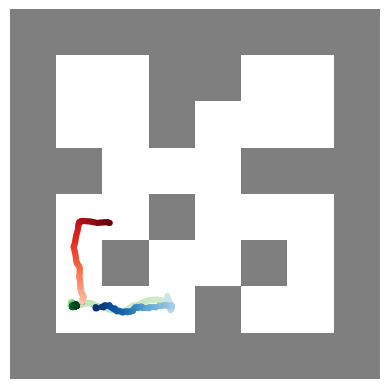

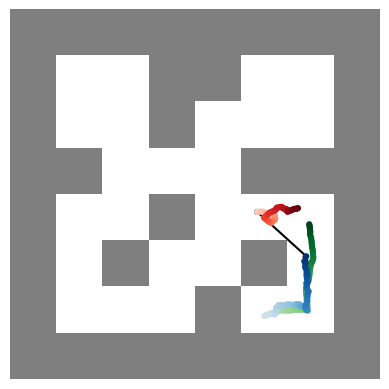

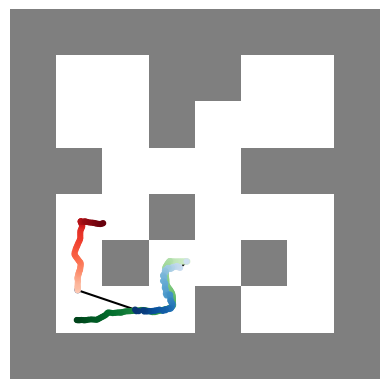

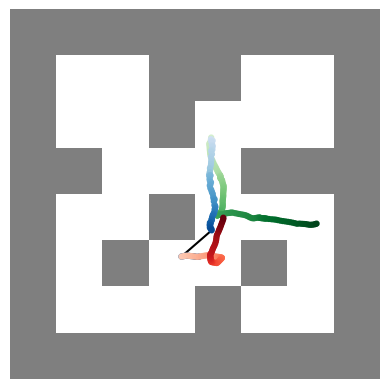

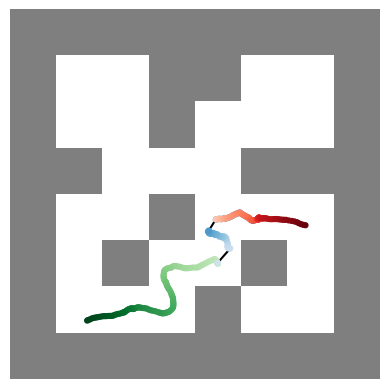

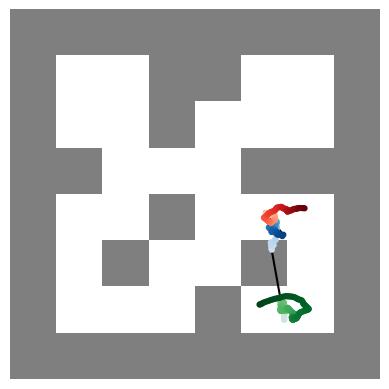

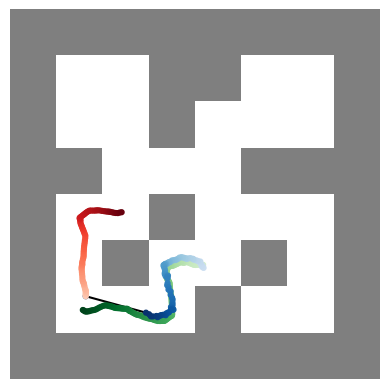

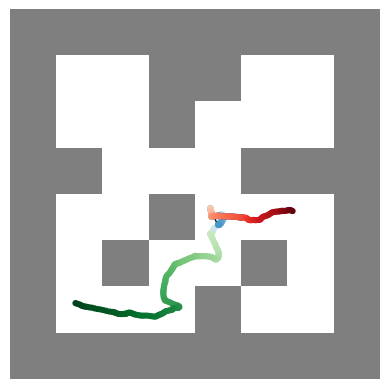

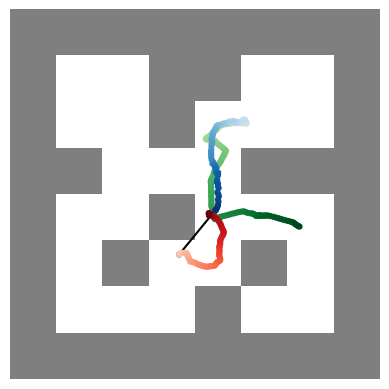

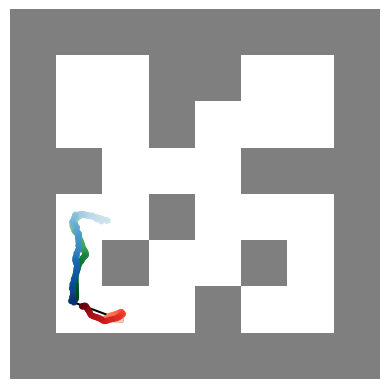

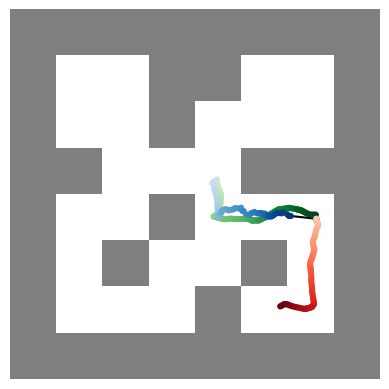

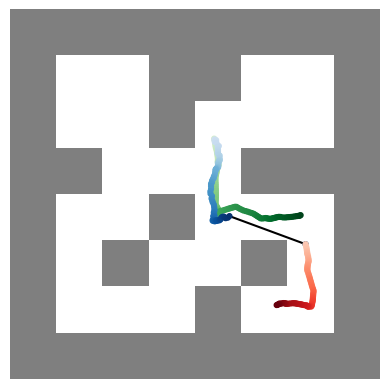

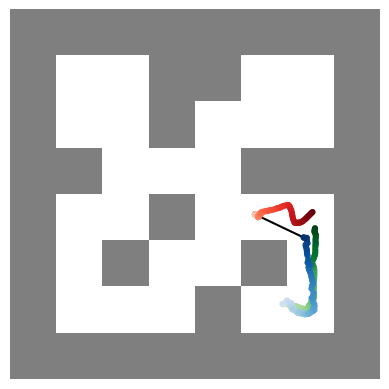

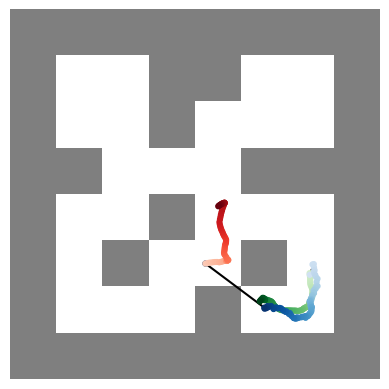

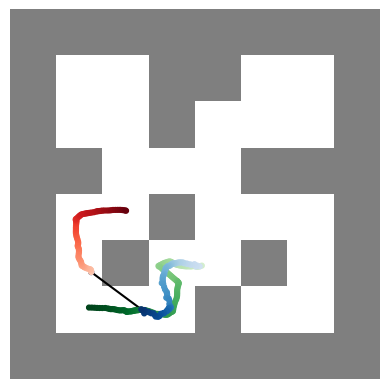

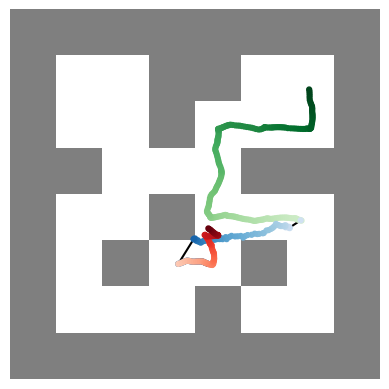

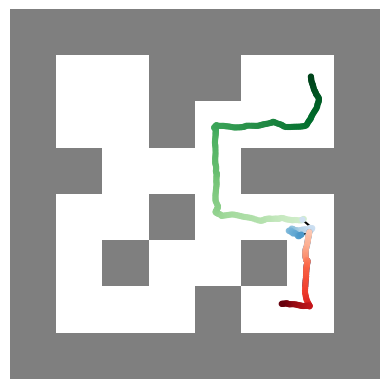

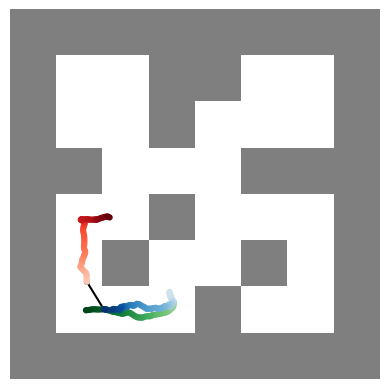

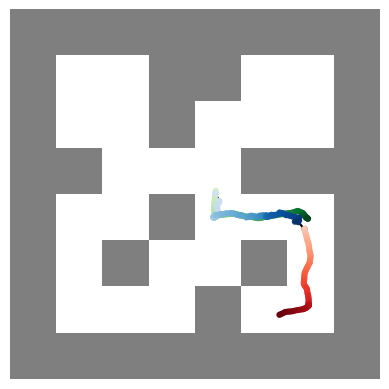

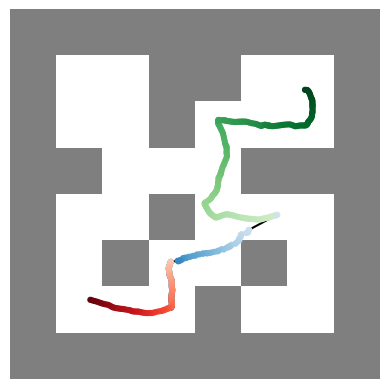

In [60]:
env_name = 'AntMaze_Medium-v4'
env = gym.make(env_name)
maze_map = np.array(env.unwrapped.maze._maze_map)
maze = env.unwrapped.maze
_background = maze_map == 1

for i in range(20):
    traj1_idx = aug_list[i][0]
    traj1_segment_idx = aug_list[i][1]-1
    traj2_idx = aug_list[i][2]
    stitch_start = aug_list[i][3]
    stitch_end = aug_list[i][4]
    stitch_obs = aug_list[i][5]

    trj1_obs = env_dataset.get_full_info_traj(traj1_idx)['obs'][traj1_segment_idx:]
    trj2_obs = expert_buffer.info[traj2_idx][1]


    plt.imshow(
        _background * 0.5,
        cmap=plt.cm.binary,
        vmin=0,
        vmax=1,
    )
    
    # trj1_obs = trj1_obs[:stitch_start]
    traj1_i = (maze.y_map_center - trj1_obs[ :, 1] -2) / maze.maze_size_scaling
    traj1_j = (trj1_obs[ :, 0] + maze.x_map_center-2) / maze.maze_size_scaling
    
    path_length = trj1_obs.shape[0]
    colors = plt.cm.Greens(np.linspace(0.2, 1, path_length))
    plt.scatter(traj1_j, traj1_i, s=12, c=colors, zorder=10)

    # trj2_obs = trj2_obs[:horizon-stitch_end]
    traj2_i = (maze.y_map_center - trj2_obs[ :, 1] -2) / maze.maze_size_scaling
    traj2_j = (trj2_obs[ :, 0] + maze.x_map_center-2) / maze.maze_size_scaling
    
    path_length = trj2_obs.shape[0]
    colors = plt.cm.Reds(np.linspace(0.2, 1, path_length))
    plt.scatter(traj2_j, traj2_i, s=12, c=colors, zorder=30)

    stitch_i = (maze.y_map_center - stitch_obs[ :, 1] -2) / maze.maze_size_scaling
    stitch_j = (stitch_obs[ :, 0] + maze.x_map_center-2) / maze.maze_size_scaling
    
    path_length = stitch_obs.shape[0]
    colors = plt.cm.Blues(np.linspace(0.2, 1, path_length))
    plt.scatter(stitch_j, stitch_i, s=12, c=colors, zorder=20)
    plt.plot(stitch_j, stitch_i, color='black')
    plt.axis('off')
    plt.show()
    

In [61]:
# sample 'bad' trajs
aug_list_v2 = []
while len(aug_list_v2) <20:
    expert_infos = [] 
    for idx in range(0, stitch_batch_size): 
        traj_i = sample_traj_from_dict(top_k_trajs) 
        i = traj_i[0] 
        expert_info_i = env_dataset.get_full_info_traj(i) 
    
        l_1 = traj_i[1]
        r_1 = l_1 + horizon
    
        # l_1 
        original_discounted_reward = 0
        for t in range(expert_info_i['horizon'] - 1, l_1 - 1, -1): 
            original_discounted_reward = original_discounted_reward * 0.99 + expert_info_i['rew'][t] 
        
        for _ in ['act', 'obs', 'rew', 'region_idx']: 
            expert_info_i[_] = expert_info_i[_][l_1 : r_1]
        expert_info_i['original_discounted_reward'] = original_discounted_reward
        expert_info_i['traj_idx'] = i
        expert_info_i['segment_idx'] = l_1
        expert_infos.append(expert_info_i) 
    
    traj1 = expert_infos
    traj_1_obs = [
        np.expand_dims(_["obs"], axis=0) for _ in traj1
    ]  # traj_1_obs.shape is (100, 11)
    
    traj_1_obs = np.concatenate(traj_1_obs, axis=0)
    for i in range(0, traj_1_obs.shape[0]):
        traj_1_obs[i] = dataset.normalizer.normalize(
            np.expand_dims(traj_1_obs[i], axis=0), "observations"
        )
    # generate new samples from the start of 'bad' trajs
    cond = np.ones(shape=(stitch_batch_size, horizon, 2 * obs_dim))
    cond[:, :, obs_dim:] = 0
    cond[:, :dream_len, :obs_dim] = 0
    cond[:, :dream_len, obs_dim:] = traj_1_obs[:, :dream_len, :]
    conditions = torch.tensor(cond).to(device)
    returns = to_device(test_ret * torch.ones(stitch_batch_size, 1), device)
    
    samples = trainer.ema_model.conditional_sample(
        conditions, returns=returns, verbose=False
    )  # shape is [1, 100, 11]
    np_samples = to_np(samples)
    
    
    # find "good" and near trajs
    cond_p = np.ones(shape=(stitch_batch_size, horizon, 2 * obs_dim))
    mark_succ = np.zeros(shape=(stitch_batch_size,))
    positions = []
    good = True
    i = 0
    # while not good:
    for i in range(0, stitch_batch_size):
        region_idx1 = traj1[i]['region_idx'][0]
        # pdb.set_trace()
        # sample a batch of optimal trajectories
        region_idx2 = region_idx1
        available_positions = []
        n_try = 0
        while len(available_positions) == 0:
            info_batch, obs_matrix = expert_buffer.sample_batch_traj(
                sample_optim_batch, dataset
            )
            
            # see which trajectory has a similarity greater than threshold
            
            
            for cur_pos in range(stitch_L, stitch_R):
                #cosin_sim = cosine_similarity(np_samples[i][cur_pos], obs_matrix)
                cosin_sim = comp_distance(np_samples[i][cur_pos][:2], obs_matrix[:,:2])
                # pdb.set_trace()
                if np.min(cosin_sim) > dreamer_similarity:
                    continue
                # temp_pos = list(np.where(cosin_sim >= dreamer_similarity)[0])
                temp_pos = list(np.where(cosin_sim <= dreamer_similarity)[0])
                for pos in temp_pos:
                    region_idx2 = info_batch[pos][3][0]
                    if (region_idx2 //2) != (region_idx1 //2):
                        available_positions.append(pos)
            n_try += 1
            # if n_try % 1 == 0:
            #     print(f'tried {n_try} times')
            if n_try >  3:
                # pdb.set_trace()
                good = False
                break

        available_positions = list(set(available_positions))
        
        if len(available_positions) == 0:
            # pdb.set_trace()
            # mark_succ[i] = 0
            positions.append([0, 0])
            continue
        
        mark_succ[i] = 1
        
        # print(len(available_positions))
        # find stitch position
        
        chosen_index = random.randint(0, len(available_positions) - 1)
        expert_info_j = {"obs": info_batch[available_positions[chosen_index]][1]}
        traj2 = expert_info_j
        traj_2_obs = traj2["obs"]
        traj_2_obs = np.expand_dims(traj_2_obs, axis=0)
        traj_2_obs = dataset.normalizer.normalize(traj_2_obs, "observations")
        traj_2_idx = info_batch[available_positions[chosen_index]][4]
        
        best_pos = 0
        best_ans = float('inf')
        for _ in range(stitch_L, stitch_R):
            # pdb.set_trace()
            dist_i = comp_distance(traj_2_obs[0][0][:2], np_samples[i][_][:2])
            
            # dist_i = cosine_similarity(
            #     traj_2_obs[0][0], np.expand_dims(np_samples[i][_], axis=0)
            # )
            if dist_i < best_ans:
                best_ans = dist_i
                best_pos = _
        
        start_index = dream_len
        end_index = best_pos - 1
        
        positions.append([start_index, end_index, traj_2_idx])
        cond_p[i][:, obs_dim:] = 0
        cond_p[i][:start_index, :obs_dim] = 0
        cond_p[i][:start_index, obs_dim:] = traj_1_obs[i][:start_index]
        cond_p[i][end_index + 1 :, :obs_dim] = 0
        cond_p[i][end_index + 1 :, obs_dim:] = traj_2_obs[0][: horizon - best_pos]
    
    # pdb.set_trace()
    conditions_p = torch.tensor(cond_p).to(device)
    returns_p = to_device(test_ret * torch.ones(stitch_batch_size, 1), device)
    samples_p = trainer.ema_model.conditional_sample(
        conditions_p, returns=returns_p, verbose=False
    )  # shape is [64, 100, 11]
    np_samples_p = to_np(samples_p)
    obss_p = dataset.normalizer.unnormalize(np_samples_p, "observations")
    
    
    succ_cnt = 0
    
    
    generated_transitions = 0
    
    print(sum(mark_succ))
    if sum(mark_succ) == 0:
        print(f'no trj2 found')
        continue
    # pdb.set_trace()
        
    
    total_number_traj = sum(mark_succ)
    filtered_number_traj = 0
    
    for j in range(0, stitch_batch_size):
    
        # failed to reach threshold
        if mark_succ[j] < 0.5:
            print(f'{j}th sample no stitching')
            continue
        end_index = positions[j][1]
        start_index = positions[j][0]
        traj_2_idx = positions[j][2]
        
        best_pos = end_index + 1
        len_path_data = end_index - start_index + 2
        return_info = {}
        return_info["act"] = np.zeros(shape=(len_path_data, action_dim))
        return_info["rew"] = np.zeros(shape=(len_path_data))
        return_info["obs"] = np.zeros(shape=(len_path_data + 1, obs_dim))
    
        normed_1 = []
        normed_2 = []
        normed_actions = []

        dist = np.linalg.norm(obss_p[j][:-1,:2] - obss_p[j][1:,:2], axis=-1)
        if (dist > 0.45).any():
            jump = dist.max()
            print(f'found jumps: {jump}')
            continue
            
        FLAG = False
        for i in range(start_index, end_index + 2):
            obs_comb = torch.cat(
                [samples_p[j : j + 1, i - 1, :], samples_p[j : j + 1, i, :]], dim=-1
            )
            obs_comb = obs_comb.reshape(-1, 2 * obs_dim)
            action = trainer.ema_model.inv_model(obs_comb)  # [1,3]
            action = to_np(action)
            normed_actions.append(action)
            continue
    
        normed_actions = np.concatenate(normed_actions, axis=0)
        un_normed_actions = dataset.normalizer.unnormalize(normed_actions, "actions")
    
        for i in range(start_index, end_index + 2):
            dynamics_info = dynamics_model.predict(
                torch.as_tensor(obss_p[j][i - 1], dtype=torch.float32).to(device),
                torch.as_tensor(un_normed_actions[i - start_index], dtype=torch.float32)
                .to(device)
                .squeeze(),
            )
            normed_1.append(np.expand_dims(obss_p[j][i], axis=0))
            normed_2.append(dynamics_info["next_obs"])
            if dynamics_info["done"][0][0] == True:
                print("Ends in {}, invalid!".format(i))
                FLAG = True
                break
            return_info["rew"][i - start_index] = dynamics_info["reward"][0][0]
            i_action = to_np(un_normed_actions[i - start_index])
            return_info["act"][i - start_index] = i_action
    
        if FLAG == True:
            continue
    
        normed_1 = np.concatenate(normed_1, axis=0)
        normed_2 = np.concatenate(normed_2, axis=0)
    
        normed_1 = dataset.normalizer.normalize(normed_1, "observations")
        normed_2 = dataset.normalizer.normalize(normed_2, "observations")
    
        for i in range(normed_1.shape[0]):
            if np.sum((normed_1[i][:2] - normed_2[i][:2]) ** 2) > dynamics_deviate:
                FLAG = True
                
                print(f'found dynamic error')
                break
    
        if FLAG == True:
            filtered_number_traj += 1
            print(f'{j}th sample jumps')
            continue
    
        new_discounted_reward = expert_buffer.info[positions[j][2]][0]
    
        for k in range(return_info["rew"].shape[0] - 1, -1, -1):
            new_discounted_reward = new_discounted_reward * 0.99 + return_info["rew"][k]
    
        original_discounted_reward = expert_infos[j]["original_discounted_reward"]
        print(f"{original_discounted_reward} -> {new_discounted_reward}")
        # if original_discounted_reward > new_discounted_reward:
        #     print("BAD CONCATE, WARNING\n")
        #     continue
    
        succ_cnt += 1
        return_info["obs"] = obss_p[j][start_index - 1 : end_index + 2]
    
        aug_cnt = return_info["rew"].shape[0]
    
        return_info["next_obs"] = return_info["obs"][1:]
        return_info["obs"] = return_info["obs"][:-1]
        return_info["dones"] = np.full((aug_cnt,), False, dtype=bool)
    
        for _ in ["obs", "rew", "dones", "next_obs", "act"]:
            return_info[_] = return_info[_][:]
    
        generated_transitions += return_info["obs"].shape[0]
        aug_list_v2.append(
            (
                traj1[j]['traj_idx'],
                traj1[j]['segment_idx'],
                traj_2_idx,
                start_index,
                end_index,
                obss_p[j],
                return_info["obs"],
                return_info["act"],
                return_info["rew"],
                return_info["next_obs"],
                return_info["dones"],
            )
        )

262.0
0th sample no stitching
1th sample no stitching
2th sample no stitching
found jumps: 3.4470162391662598
found jumps: 5.389787673950195
5th sample no stitching
found jumps: 2.022723436355591
found jumps: 5.099322319030762
8th sample no stitching
found jumps: 0.9945554137229919
found jumps: 3.5082955360412598
found jumps: 6.096975326538086
12th sample no stitching
found jumps: 3.0169975757598877
found jumps: 5.69202184677124
found jumps: 2.499086856842041
16th sample no stitching
found jumps: 5.050206661224365
found jumps: 2.933244466781616
found jumps: 1.2669298648834229
found jumps: 4.83593225479126
21th sample no stitching
found jumps: 5.267914295196533
found jumps: 2.560159683227539
24th sample no stitching
25th sample no stitching
26th sample no stitching
found jumps: 5.483620643615723
found jumps: 4.956934452056885
found jumps: 1.8876501321792603
found jumps: 5.571885108947754
31th sample no stitching
32th sample no stitching
33th sample no stitching
34th sample no stitching


In [131]:
len(aug_list_v2)

103

In [132]:
traj_2_obs.shape

(1, 100, 29)

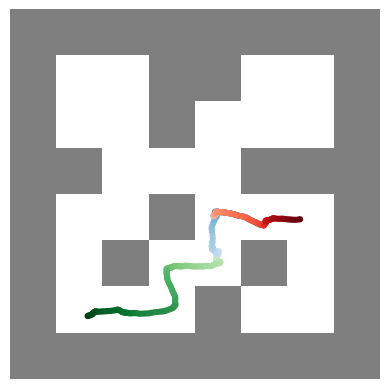

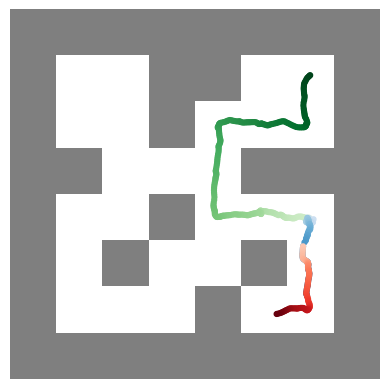

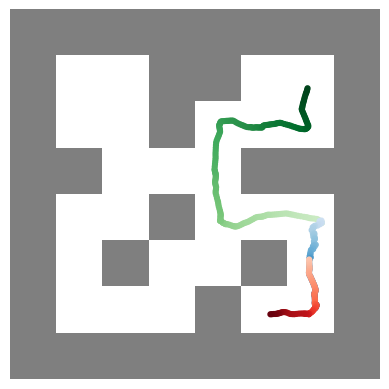

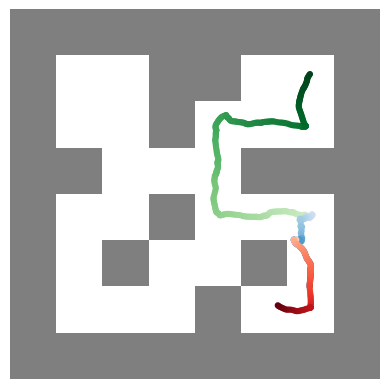

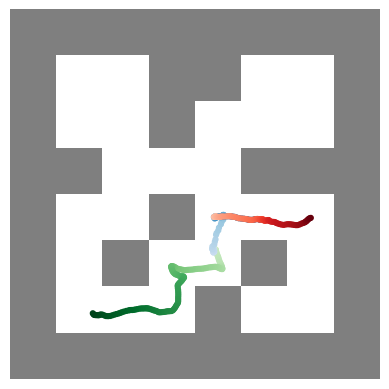

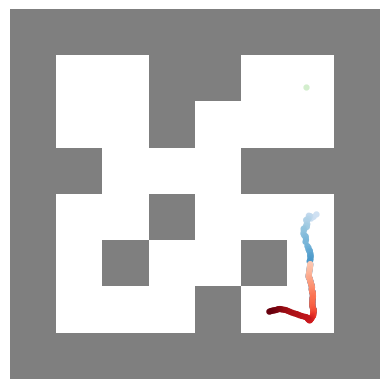

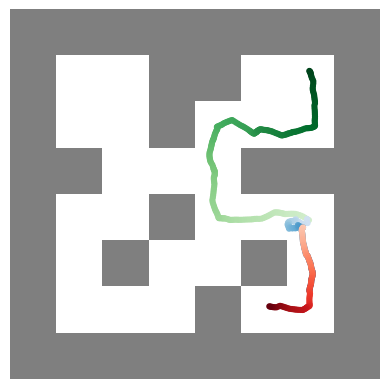

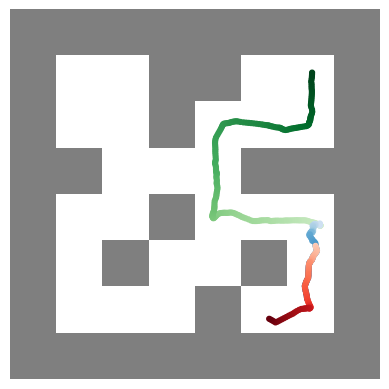

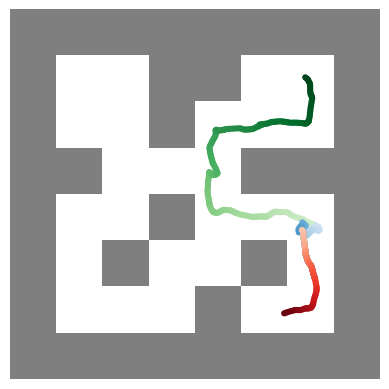

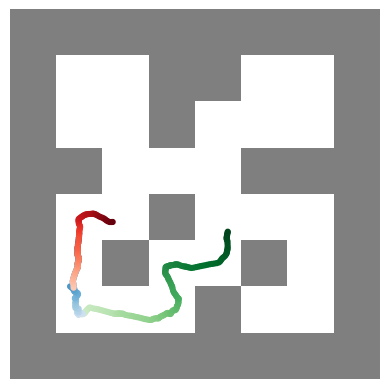

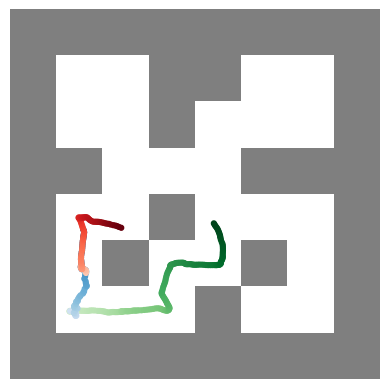

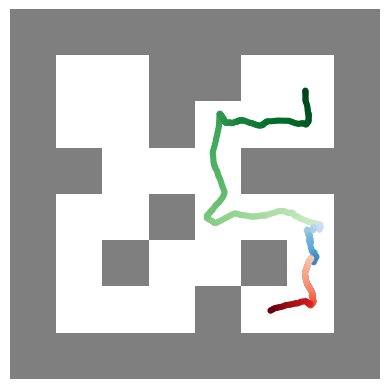

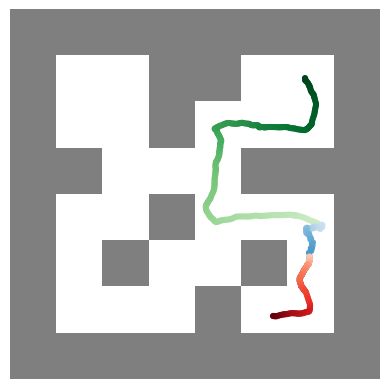

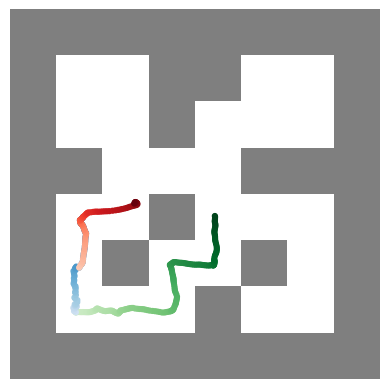

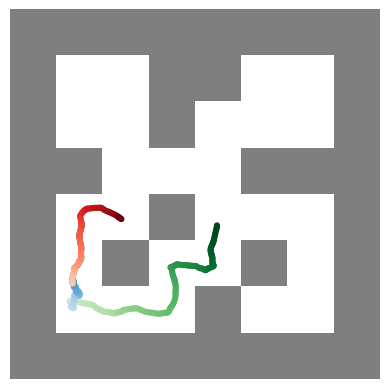

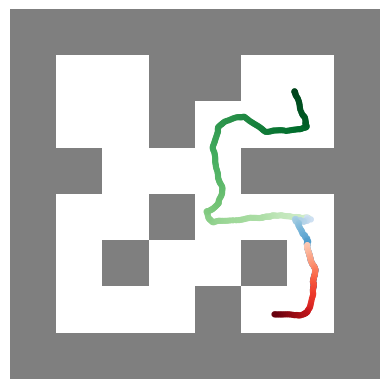

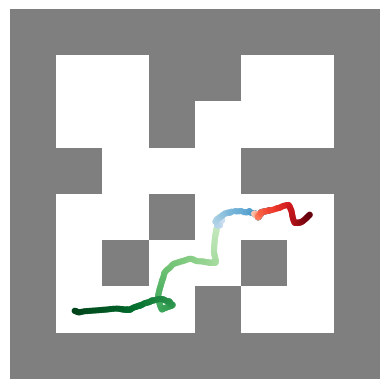

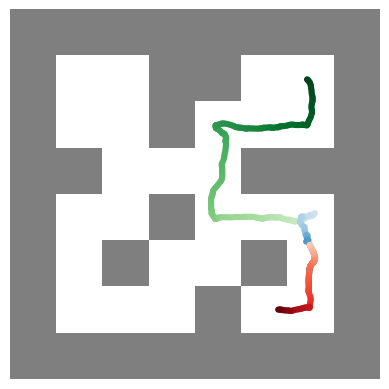

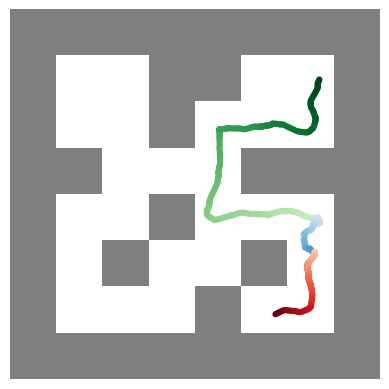

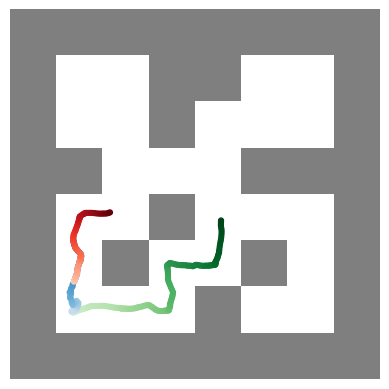

In [62]:
env_name = 'AntMaze_Medium-v4'
env = gym.make(env_name)
maze_map = np.array(env.unwrapped.maze._maze_map)
maze = env.unwrapped.maze
_background = maze_map == 1

for i in range(20):
    traj1_idx = aug_list_v2[i][0]
    traj1_segment_idx = aug_list_v2[i][1]-1
    traj2_idx = aug_list_v2[i][2]
    stitch_start = aug_list_v2[i][3]
    stitch_end = aug_list_v2[i][4]
    stitch_obs = aug_list_v2[i][5]

    trj1_obs = env_dataset.get_full_info_traj(traj1_idx)['obs'][traj1_segment_idx:]
    trj2_obs = expert_buffer.info[traj2_idx][1]


    plt.imshow(
        _background * 0.5,
        cmap=plt.cm.binary,
        vmin=0,
        vmax=1,
    )
    
    # trj1_obs = trj1_obs[:stitch_start]
    traj1_i = (maze.y_map_center - trj1_obs[ :, 1] -2) / maze.maze_size_scaling
    traj1_j = (trj1_obs[ :, 0] + maze.x_map_center-2) / maze.maze_size_scaling
    
    path_length = trj1_obs.shape[0]
    colors = plt.cm.Greens(np.linspace(0.2, 1, path_length))
    plt.scatter(traj1_j, traj1_i, s=12, c=colors, zorder=10)

    # trj2_obs = trj2_obs[:horizon-stitch_end]
    traj2_i = (maze.y_map_center - trj2_obs[ :, 1] -2) / maze.maze_size_scaling
    traj2_j = (trj2_obs[ :, 0] + maze.x_map_center-2) / maze.maze_size_scaling
    
    path_length = trj2_obs.shape[0]
    colors = plt.cm.Reds(np.linspace(0.2, 1, path_length))
    plt.scatter(traj2_j, traj2_i, s=12, c=colors, zorder=30)

    stitch_i = (maze.y_map_center - stitch_obs[ :, 1] -2) / maze.maze_size_scaling
    stitch_j = (stitch_obs[ :, 0] + maze.x_map_center-2) / maze.maze_size_scaling
    
    path_length = stitch_obs.shape[0]
    colors = plt.cm.Blues(np.linspace(0.2, 1, path_length))
    plt.scatter(stitch_j, stitch_i, s=12, c=colors, zorder=20)
    plt.plot(stitch_j, stitch_i, color='black')
    plt.axis('off')
    plt.show()
    

In [81]:
stitch_obs[-2:,:2]

array([[ 3.0424042, -5.2957487],
       [ 3.1347866, -5.283267 ]], dtype=float32)

In [82]:
trj2_obs[:2,:2]

array([[ 5.4628463, -9.479283 ],
       [ 5.6170835, -9.501962 ]], dtype=float32)

In [83]:
stitch_end

40

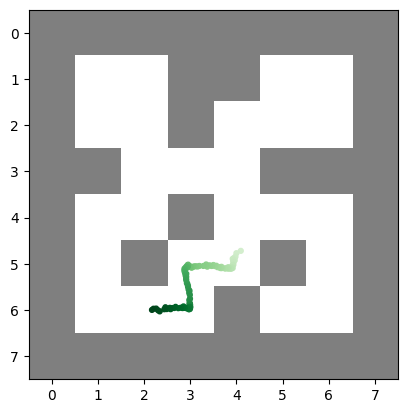

In [35]:
env_name = 'AntMaze_Medium-v4'
env = gym.make(env_name)
maze_map = np.array(env.unwrapped.maze._maze_map)
maze = env.unwrapped.maze
_background = maze_map == 1

plt.imshow(
        _background * 0.5,
        cmap=plt.cm.binary,
        vmin=0,
        vmax=1,
    )

n_sample = np_samples.shape[0]
observations = dataset.normalizer.unnormalize(
                np_samples, "observations"
            )
for idx in range(1):
    pos = observations[idx, :, :2]
    i = (maze.y_map_center - pos[ :, 1] -2) / maze.maze_size_scaling
    j = (pos[ :, 0] + maze.x_map_center-2) / maze.maze_size_scaling
    
    path_length = pos.shape[0]
    colors = plt.cm.Greens(np.linspace(0.2, 1, path_length))
    plt.scatter(j, i, s=12, c=colors, zorder=20)
plt.show()

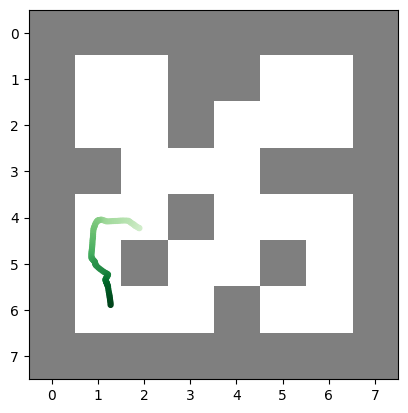

In [37]:
plt.imshow(
        _background * 0.5,
        cmap=plt.cm.binary,
        vmin=0,
        vmax=1,
    )

n_sample = traj_2_obs.shape[0]
observations = dataset.normalizer.unnormalize(
                traj_2_obs, "observations"
            )
for idx in range(1):
    pos = observations[idx, :, :2]
    i = (maze.y_map_center - pos[ :, 1] -2) / maze.maze_size_scaling
    j = (pos[ :, 0] + maze.x_map_center-2) / maze.maze_size_scaling
    
    path_length = pos.shape[0]
    colors = plt.cm.Greens(np.linspace(0.2, 1, path_length))
    plt.scatter(j, i, s=12, c=colors, zorder=20)
plt.show()

In [156]:

class AntmazeWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        """Constructor for the observation wrapper."""
        gym.ObservationWrapper.__init__(self, env)

        self.observation_space['observation'] = gym.spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.observation_space['observation'].shape[0] + 2,), dtype=np.float64
        )

    def reset(
        self, *, seed=None, options=None,
    ):
        obs, info = self.env.reset(seed=seed, options=options)
        return self.observation(obs), info

    def step(
        self, action
    ):
        """Modifies the :attr:`env` after calling :meth:`step` using :meth:`self.observation` on the returned observations."""
        observation, reward, terminated, truncated, info = self.env.step(action)
        return self.observation(observation), reward, terminated, truncated, info

    def observation(self, observation):
        """Returns a modified observation.

        Args:
            observation: The :attr:`env` observation

        Returns:
            The modified observation
        """
        observation['observation'] = np.concatenate((observation['achieved_goal'],  observation['observation']), axis=0)
        return observation

env_name = 'AntMaze_Medium-v4'
env = gym.make(env_name)
env = AntmazeWrapper(env)

In [195]:

total_l = 0
error = []
idx = -1
while total_l < 1000:
    stitch_obs = aug_list[-1][6]
    stitch_act = aug_list[-1][7]
    env.reset()
    l = stitch_obs.shape[0]
    total_l += l
    
    true_s = stitch_obs[0]
    for i in range(l):
        stitch_s = stitch_obs[i]
        error.append(np.linalg.norm(stitch_s - true_s))
        env.ant_env.set_state(stitch_s[:15], stitch_s[15:])
        next_s = env.step(stitch_act[i])
        next_s = next_s[0]['observation']
        true_s = next_s
    idx -= 1
print(f'stitch error with: {sum(error) / total_l}')

stitch error with: 3.4308606905932533


(array([216., 216., 216.,  90.,  90.,  18.,  72.,  36.,  18.,  72.]),
 array([ 0.        ,  1.05582653,  2.11165306,  3.16747959,  4.22330612,
         5.27913265,  6.33495919,  7.39078572,  8.44661225,  9.50243878,
        10.55826531]),
 <BarContainer object of 10 artists>)

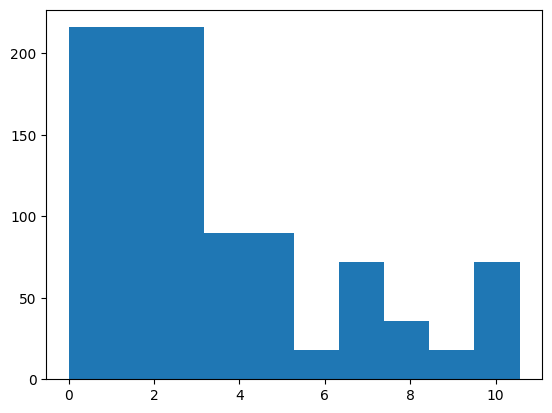

In [196]:
plt.hist(error)

In [197]:
total_l = 0
error = []
idx = -1
while total_l < 1000:
    stitch_obs = aug_list_v2[-1][6]
    stitch_act = aug_list_v2[-1][7]
    env.reset()
    l = stitch_obs.shape[0]
    total_l += l
    
    true_s = stitch_obs[0]
    for i in range(l):
        stitch_s = stitch_obs[i]
        error.append(np.linalg.norm(stitch_s - true_s))
        env.ant_env.set_state(stitch_s[:15], stitch_s[15:])
        next_s = env.step(stitch_act[i])
        next_s = next_s[0]['observation']
        true_s = next_s
    idx -= 1
print(f'stitch error with: {sum(error) / total_l}')

stitch error with: 2.598877081102126


(array([ 75., 125., 200., 200., 250.,  25., 100.,  25.,   0.,  25.]),
 array([0.        , 0.70073652, 1.40147304, 2.10220956, 2.80294607,
        3.50368259, 4.20441911, 4.90515563, 5.60589215, 6.30662867,
        7.00736519]),
 <BarContainer object of 10 artists>)

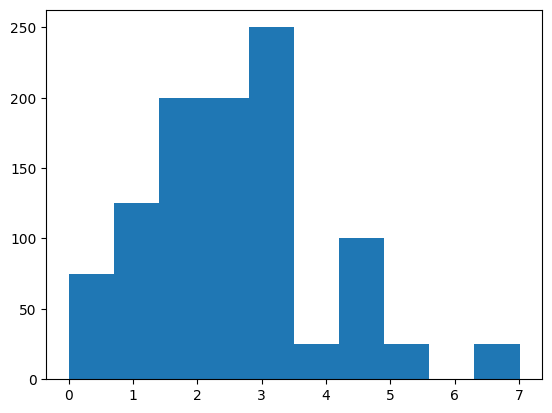

In [198]:
plt.hist(error)
    

In [201]:
true_s

array([ 7.93203944e+00, -1.93388654e+00,  7.94147396e-01,  5.81298288e-01,
        1.17801592e-01,  1.18361295e-01, -7.96370322e-01, -3.32054312e-02,
        5.10774652e-01,  5.33746423e-01, -5.56300811e-01, -5.26915202e-01,
       -5.21738056e-01, -5.35414973e-01,  1.24733836e+00, -3.45556293e-01,
        1.40960741e+00, -1.57010615e-02,  4.14975117e-01,  5.08472334e-01,
        1.71916207e+00, -2.13001282e+00,  1.85915885e-01, -2.63683558e-01,
       -9.07947741e-01,  1.67590887e-02, -1.25009629e-03, -3.30197484e-01,
        1.20626551e+00])

In [202]:
stitch_s

array([ 7.9516563 , -2.0046673 ,  0.78294855,  0.5443474 ,  0.10189557,
        0.11630803, -0.8126698 ,  0.05715352,  0.542552  ,  0.55597574,
       -0.53088313, -0.52411556, -0.5197135 , -0.5219739 ,  1.099865  ,
       -0.37241888,  1.4606423 ,  0.46744823,  0.21365166,  0.5368805 ,
        1.3786831 , -1.4789686 , -0.35426807, -0.30524826, -0.10750771,
        0.12321854, -0.15355778,  1.3584995 ,  1.2317038 ], dtype=float32)

15

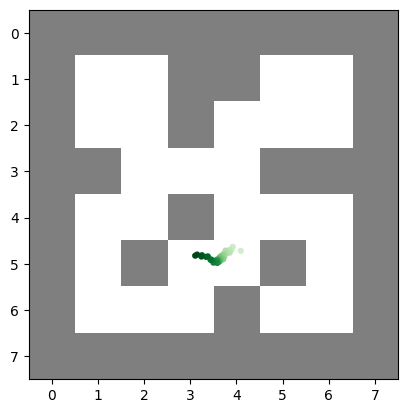

In [46]:
plt.imshow(
        _background * 0.5,
        cmap=plt.cm.binary,
        vmin=0,
        vmax=1,
    )




pos = return_info['obs'][ :, :2]
i = (maze.y_map_center - pos[ :, 1] -2) / maze.maze_size_scaling
j = (pos[ :, 0] + maze.x_map_center-2) / maze.maze_size_scaling

path_length = pos.shape[0]
colors = plt.cm.Greens(np.linspace(0.2, 1, path_length))
plt.scatter(j, i, s=12, c=colors, zorder=20)
plt.show()

In [48]:
dynamics_deviate

1.5